In [1]:
import os, shutil
import torch
import time
import warnings
from botorch.exceptions import BadInitialCandidatesWarning
import pdb
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
import head
import numpy as np
from head.metrics import euclidean_dist
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model
from botorch.optim.optimize import optimize_acqf_discrete
from botorch.acquisition.monte_carlo import qUpperConfidenceBound
from botorch.acquisition.objective import LinearMCObjective
from matplotlib.cm import ScalarMappable

N_UVVIS_SAMPLES = 10
N_SAS_SAMPLES = 100
NUM_GRID_PERDIM = 20
BATCH_SIZE = 5
N_ITERATIONS = 4
R_mu = 20
R_sigma = 1e-2

expt = {}
EXPT_ID = 0

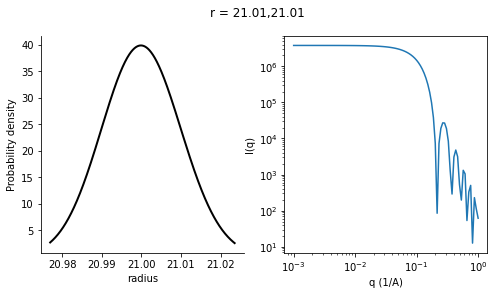

In [2]:
sim = head.Emulator()

fig, axs = plt.subplots(1,2,figsize=(4*2,4))

sim.make_structure(r_mu=R_mu,r_sigma=R_sigma)
sim.plot_radii(axs[0])
axs[0].set_xlabel('radius')
axs[0].set_ylabel('Probability density')

q, st = sim.get_saxs(n_samples=N_SAS_SAMPLES)
axs[1].loglog(q, st)
plt.setp(axs[1], xlabel='q (1/A)', ylabel='I(q)')
fig.suptitle('r = '+','.join('%.2f'%i for i in sim.radii))
plt.show()

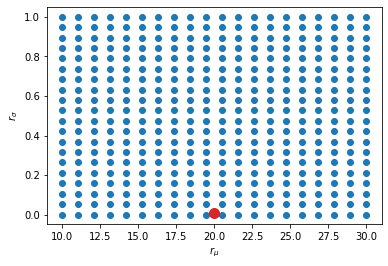

In [3]:
X = np.linspace(10,30, num=NUM_GRID_PERDIM) 
Y = np.linspace(1e-3,1, num=NUM_GRID_PERDIM)
grid = head.Grid(X,Y)
fig, ax = plt.subplots()
ax.scatter(grid.points[:,0], grid.points[:,1], label='Grid points')
ax.scatter(R_mu, R_sigma, s=100, color='tab:red', label='Target')
ax.set_xlabel(r'$r_{\mu}$')
ax.set_ylabel(r'$r_{\sigma}$')
plt.show()

In [4]:
def oracle(x):
    """Scoring function at a given input location
    Uses the simulator sim to generate response spectra at a given locations
    and return a similarity score to target spectra
    """
    global EXPT_ID
    x_np = x.cpu().numpy()
    sim.make_structure(r_mu=x_np[0],r_sigma=x_np[1])
    q, si = sim.get_saxs(n_samples=N_SAS_SAMPLES)
    dist_sas = euclidean_dist(np.log10(si),np.log10(st))
    expt[EXPT_ID] = [q, si, dist_sas]
    EXPT_ID += 1
    
    return torch.tensor([dist_sas])

def batch_oracle(x):
    out = []
    for xi in x.squeeze(1):
        out.append(oracle(xi))
    return torch.stack(out, dim=0).to(**tkwargs)

In [5]:
problem = lambda s : batch_oracle(s)

# sample initial data
def generate_initial_data(n=6):
    points = torch.from_numpy(grid.points)
    soboleng = torch.quasirandom.SobolEngine(dimension=1)
    train_xid = torch.floor(soboleng.draw(n)*len(grid)).to(**tkwargs)
    train_x = points[train_xid.long(),:]
    train_obj = problem(train_x)
    
    return train_x.squeeze().to(**tkwargs), train_obj.to(**tkwargs)

N_INIT_SAMPLES = 10
train_x, train_obj = generate_initial_data(n=N_INIT_SAMPLES)
print('Generated %d samples randomly'%N_INIT_SAMPLES, train_x.shape, train_obj.shape)

Generated 10 samples randomly torch.Size([10, 2]) torch.Size([10, 1])


In [6]:
def initialize_model(train_x, train_obj):
    # define models for objective and constraint
    model = SingleTaskGP(train_x, train_obj, 
    outcome_transform=Standardize(m=train_obj.shape[-1]))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

mll, model = initialize_model(train_x, train_obj)

# 3. Define acqusition function

obj = LinearMCObjective(weights=torch.tensor([1.0]).to(**tkwargs))
acq_fun = lambda model: qUpperConfidenceBound(model, beta=0.1, objective=obj)

In [7]:
def selector(f, q = BATCH_SIZE):
    choices = torch.from_numpy(grid.points).to(**tkwargs)
    new_x, _ = optimize_acqf_discrete(
        acq_function = f,
        q=q,
        choices = choices
    )
    new_obj = problem(new_x)
    return new_x, new_obj

In [8]:
torch.manual_seed(0)

assert len(grid)>(BATCH_SIZE*N_ITERATIONS + N_INIT_SAMPLES) ,"Not enough samples in the grid"

# run N_ITERATIONS rounds of BayesOpt after the initial random batch
for iteration in range(1, N_ITERATIONS + 1):    
    print('Iteration : %d/%d'%(iteration, N_ITERATIONS))
    # fit the models
    fit_gpytorch_model(mll)

    # define the acquisition modules using a QMC sampler
    acquisition = acq_fun(model)

    # optimize acquisition functions and get new observations
    new_x, new_obj = selector(acquisition)

    # update training points
    train_x = torch.cat([train_x, new_x])
    train_obj = torch.cat([train_obj, new_obj])

    # reinitialize the models so they are ready for fitting on next iteration
    # Note: we find improved performance from not warm starting the model hyperparameters
    # using the hyperparameters from the previous iteration
    mll, model = initialize_model(train_x, train_obj)

    best = train_obj.max(axis=0).values
    print('Best %.2f'%(best))

Iteration : 1/4
Best -1.24
Iteration : 2/4
Best -0.92
Iteration : 3/4
Best -0.92
Iteration : 4/4
Best -0.92


In [9]:
# obtain best sample and corresponding objective
from botorch.acquisition import PosteriorMean
from botorch.acquisition.objective import ScalarizedObjective
objective = ScalarizedObjective(weights=torch.tensor([1.0]).to(**tkwargs))

opt_x, opt_obj = selector(PosteriorMean(model, objective=objective), q=1)
print('Optimal location: ',opt_x,'\nOptimal objectives: ', opt_obj)

Optimal location:  tensor([[20.5263,  0.2639]], dtype=torch.float64) 
Optimal objectives:  tensor([[-2.2036]], dtype=torch.float64)
